In [1]:
import os
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import numpy as np
import pandas as pd

label_names = ["Gland", "Non-Gland", "Tumor"]


In [2]:
def train_test_split(dataset, test_ratio=0.2):
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    split = int(len(dataset) * (1 - test_ratio))
    train_indices, test_indices = indices[:split], indices[split:]
    
    return torch.utils.data.Subset(dataset, train_indices), torch.utils.data.Subset(dataset, test_indices)


def extract_features(loader, model):
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in loader:
            feats = model(images).squeeze(-1).squeeze(-1).numpy()  # Flatten features
            features.append(feats)
            labels.append(lbls.numpy())
    
    return np.concatenate(features), np.concatenate(labels)


def create_embedding_dataframe(_full_train_feature_map_set, _full_train_label_set):
    reduction_fitter = TSNE(random_state=42)
    embeddings = reduction_fitter.fit_transform(_full_train_feature_map_set)
    embedding_dataframe = pd.DataFrame(embeddings, columns=["x_embedded", "y_embedded"])
    embedding_dataframe["label"] = _full_train_label_set
    return embedding_dataframe

def plot_tsne_embedding(_embedding_dataframe):
    colors = ["red", "green", "blue"]

    plt.style.use('seaborn-v0_8-dark')
    fig, ax = plt.subplots(figsize=(16, 10))
    for i in _embedding_dataframe["label"].unique():
        label_embedding_values = _embedding_dataframe[_embedding_dataframe.label == i]
        ax.scatter(label_embedding_values.x_embedded, label_embedding_values.y_embedded, 
                   label=label_names[i], c=colors[i], alpha=0.5)

    ax.set_xlabel("Embedded Feature 1")
    ax.set_ylabel("Embedded Feature 2")
    ax.set_title("Feature Extractor Mappings Following TSNE Reduction")
    ax.legend()
    plt.show()


class ProstateCancerDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {"gland": 0, "nongland": 1, "tumor": 2}  # Map folder names to labels

        for label_name, label_id in self.label_map.items():
            folder_path = os.path.join(self.root_dir, label_name)
            for file_name in os.listdir(folder_path):
                if file_name.endswith((".jpg", ".png")):  # Ensure we only load image files
                    self.image_paths.append(os.path.join(folder_path, file_name))
                    self.labels.append(label_id)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = PIL.Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        return self.transform(image), label
    

In [3]:
dataset_path = "Datasets/Prostate Cancer/"  

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
full_dataset = ProstateCancerDataset(dataset_path, transform)
train_dataset, test_dataset = train_test_split(full_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Colorectal Cancer Model

In [5]:
# Initialize Pre-trained ResNet**
resnet = models.resnet50(weights=None, num_classes=3)
resnet.load_state_dict(torch.load("Models/ResNet_Rmsprop_Corolectal_Cancer_pre_trained.tar"))
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # Remove the final classification layer
resnet.eval()  

train_features, train_labels = extract_features(train_loader, resnet)
test_features, test_labels = extract_features(test_loader, resnet)

classifier = LogisticRegression()
classifier.fit(train_features, train_labels)


C:\Users\trist\AppData\Local\Temp\ipykernel_30832\2690732931.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("Models/ResNet_Rmsprop_Cor

LogisticRegression()

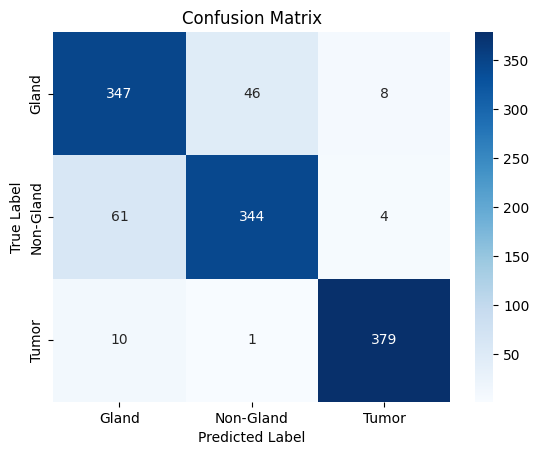

Classification Report:
              precision    recall  f1-score   support

       Gland       0.83      0.87      0.85       401
   Non-Gland       0.88      0.84      0.86       409
       Tumor       0.97      0.97      0.97       390

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



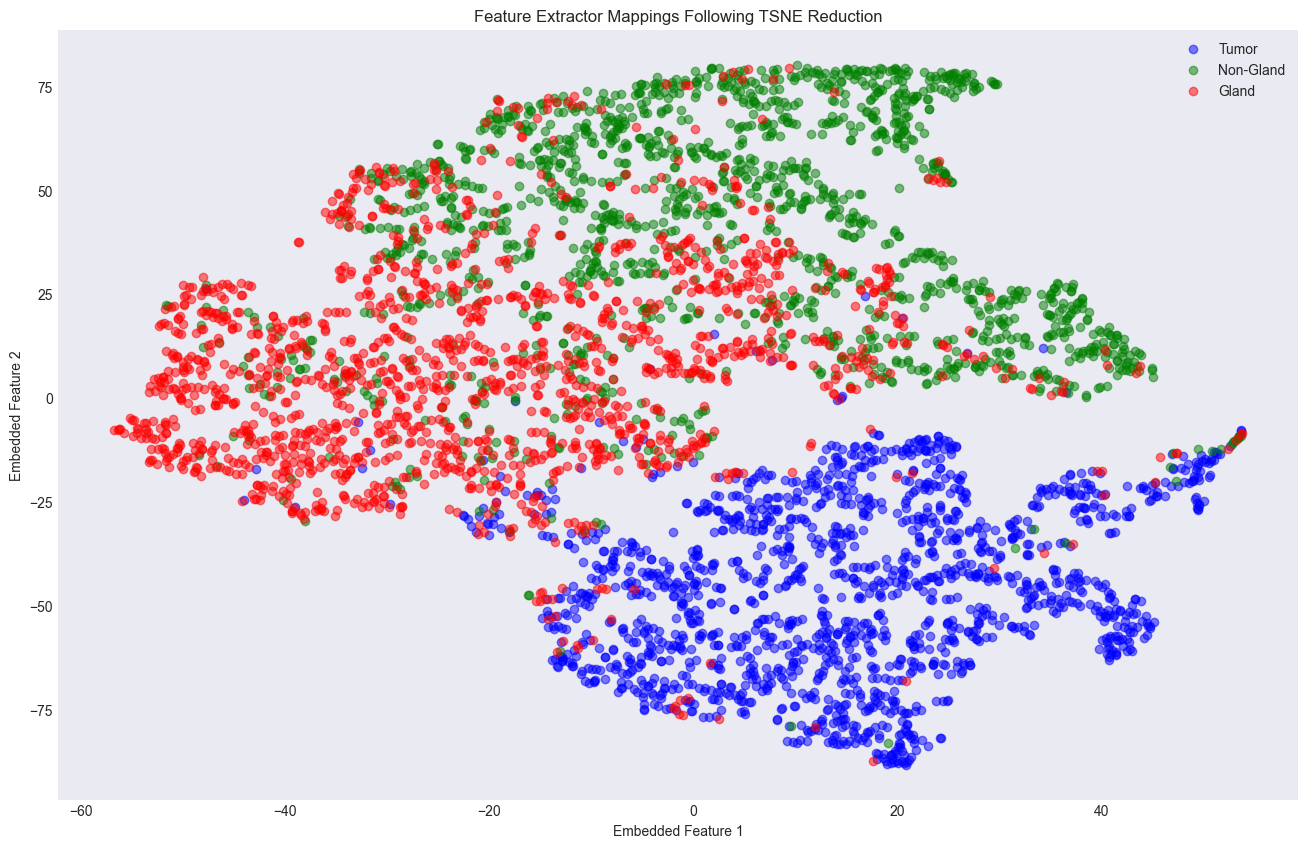

In [6]:
predictions = classifier.predict(test_features)

cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Gland", "Non-Gland", "Tumor"], yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predictions, target_names=label_names))

embedding_df = create_embedding_dataframe(train_features, train_labels)
plot_tsne_embedding(embedding_df)


- Discussion

- G

#### ImageNet Model

In [31]:
# Initialize Pre-trained ResNet**
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # Remove the final classification layer
resnet.eval()  

train_features, train_labels = extract_features(train_loader, resnet)
test_features, test_labels = extract_features(test_loader, resnet)

classifier = LogisticRegression()
classifier.fit(train_features, train_labels)


LogisticRegression()

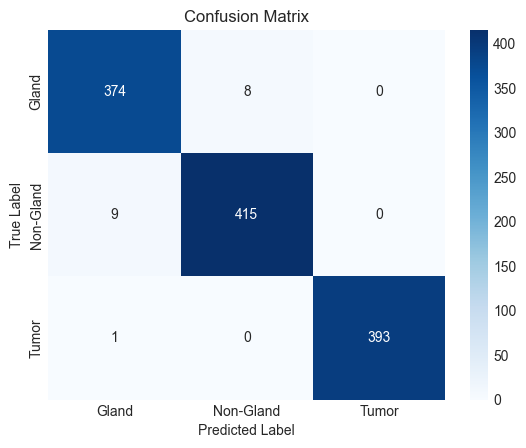

Classification Report:
              precision    recall  f1-score   support

       Gland       0.97      0.98      0.98       382
   Non-Gland       0.98      0.98      0.98       424
       Tumor       1.00      1.00      1.00       394

    accuracy                           0.98      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.98      0.99      1200



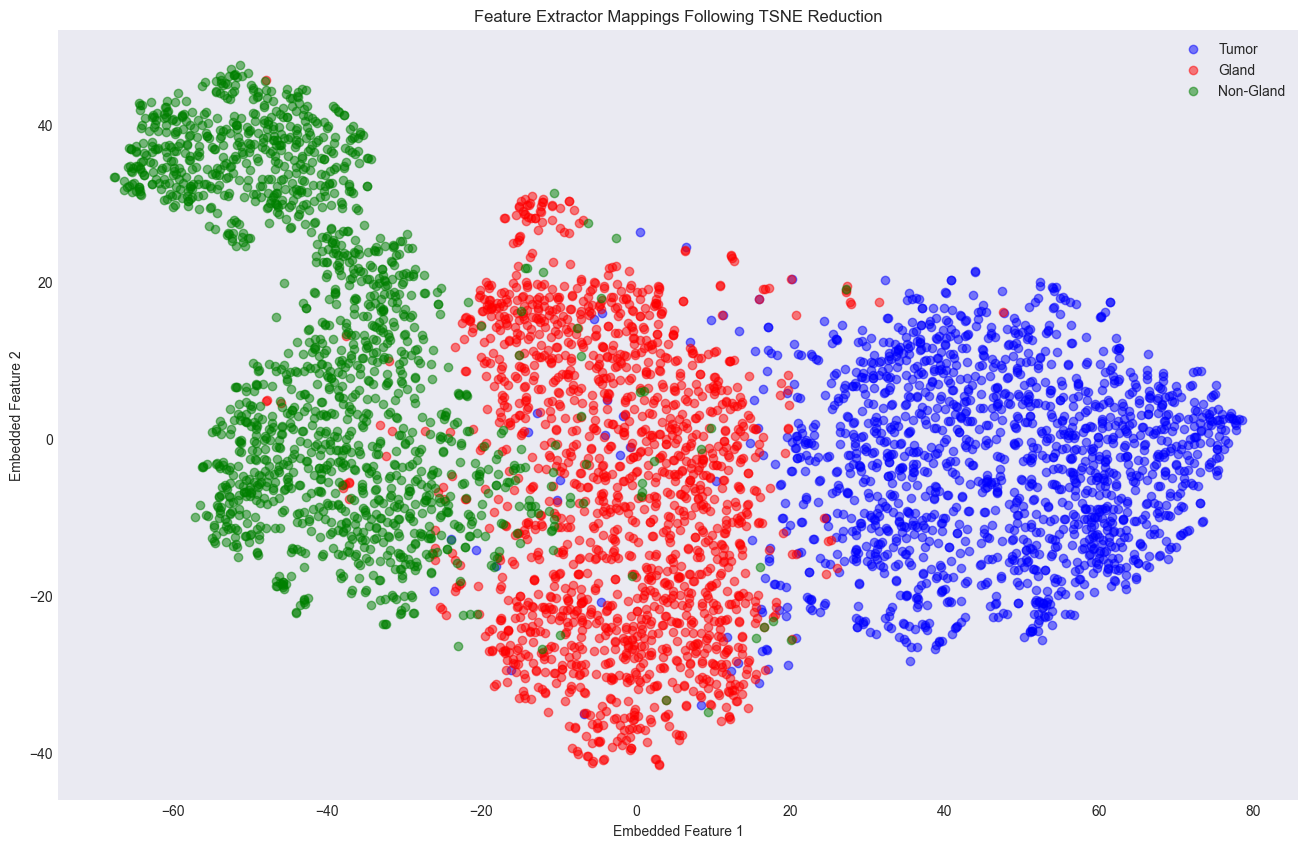

In [32]:
predictions = classifier.predict(test_features)

cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Gland", "Non-Gland", "Tumor"], yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predictions, target_names=label_names))

embedding_df = create_embedding_dataframe(train_features, train_labels)
plot_tsne_embedding(embedding_df)

- Discussion
    - ImageNet ResNet model predicts at a accuracy of +97% across all types of prostate cancer.
    - Feature extraction and data augmentation enhances the training and quality of inferred predictions through Logistic Regression model
